## ChatGPT as GameMaster of a Choose Your Own Adventure game

This is a for-fun proof-of-concept project showing how ChatGPT can be harnessed to become the Game Master of a Choose Your Own Adventure -style game. This leverages on the techniques taught in the excellent [ChatGPT: Prompt Engineering for Developers](https://www.deeplearning.ai/short-courses/chatgpt-prompt-engineering-for-developers/) course taught by Andrew Ng and Isa Fulford, coupled with a simple chat-window GUI modified from [Patrick Loeber's repo](https://github.com/patrickloeber/python-fun/blob/master/chatbot-gui/app.py). We shall call our app ***Chat-Adventure GPT*** !

We shall first detail how we build Chat-Adventure GPT, and afterward we will discuss known limitations and possible extensions. We will also provide screenshots of sample adventures that Chat-Adventure GPT has taken us on.

#### Install and import dependencies

In [ ]:
"""
Uncomment and run the below if OpenAI or tkinter (for making the chat GUI) are not\
already installed.
"""
#!pip install openai
#!pip install tk

In [1]:
import openai
import os
import re
import tkinter
from tkinter import *

To use ChatGPT, you will need to visit the [OpenAI website](https://openai.com/) and sign-up an account and get your API key, which you can insert below as 'my_key' or read-in from another file attached to your project:

In [2]:
my_key='sk-XXXXXXX' #your key here
openai.api_key = my_key

We define a helper function get_completion which calls gpt-3.5-turbo to produce a response to a chat input. The arguments are:
* input_msg_or_prompt : if input_mode is "prompt", this should just be a text string for ChatGPT to response to. Otherwise, if input_mode is "messages", this should be a list of representing the conversation history that ChatGPT should produce the next response to (more on this later) 
* model : specifies the OpenAI model being called
* temperature : 0 for deterministic 'safe' answers or closer to 1 for more creativity and randomness
* input_mode : as described above
* rtn_mode : "content_only" produces a response as string, "incl_tokens" outputs a tuple of the response string and the total number of tokens consumed by ChatGPT to generate that response (basically tracks your cost of usage!) and "raw" outputs the full response object which is essentially a dictionary

In [3]:
def get_completion(input_msg_or_prompt, model="gpt-3.5-turbo",
                   temperature=0,
                   input_mode="prompt",rtn_mode="content_only"):
    
    if input_mode=="prompt":
        assert type(input_msg_or_prompt) is str
        messages = [{"role": "user", "content": input_msg_or_prompt}]
    elif input_mode=="messages":
        assert type(input_msg_or_prompt) is list
        messages=input_msg_or_prompt
    else:
        print("incompatible input type")
        return 0
    
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
    )
    if rtn_mode=="content_only":
        return response.choices[0].message["content"]
    elif rtn_mode=="incl_tokens":
        return response.choices[0].message["content"], response.usage.total_tokens
    elif rtn_mode=="raw":
        return response

#### Format of 'messages' input:

The 'messages' input parameter as described above takes the form of a list, each element of which should be a dictionary {"role": role, "content": content}, where role can be 'system', 'assistant' or 'user' and content is the text-string for that element. When role is 'assistant' or 'user' it informs ChatGPT (which is always the 'assistant') whom that part of the conversation history belonged to.

The content ascribed to role of 'system' is especially powerful as it serves as an over-arching instruction for how the assistant should behave throughout the conversation - with careful prompt-engineering, this can be harnessed to tell ChatGPT that it should be an order-bot armed with a restaurant menu, or a shop-assistant armed with the product catalogue, etc., or in our case the Game Master of a Choose Your Own Adventure game, as below: 

In [4]:
system_content=f"""
You are the dungeon-master of a role-playing game in which the user is the \
main protagonist in the story that you shall develop for them. With each response \
you must:\
1. First, imagine and describe the next state of the story that the protagonist finds \
themselves based on the action they took in their previous response. If it is likely\
for the user's previous response to lead to their protagonist's demise, then you should\
accordingly describe this to them and inform them that their adventure is over, without\
providing further options.
2. At the end of every response where the protagonist has not met their demise, \
you must provide the user with a numbered list of two actions that their protagonist\
can take given the state of the story that you have described to them. The actions\
that you provide to them must\
be actions their protagonist could plausibly take to progress from the situation that\
you have described to them. 

In fewer than ten user responses, you must conclude the story by responding with a\
narratively satisfying conclusion to the story that the user's protagonist has been \
participating in, and inform them that their adventure has reached its conclusion.

The setting of the game is a Lovecraftian horror mystery.

"""

initial_prompt=f"""
Describe to me the starting scene of a Lovecraftian horror mystery in which\
I am the main protagonist, and a numbered list of the two possible actions\
that I can take
"""

initial_message_chain=[
    {'role':'system', 'content':system_content},
    {'role':'user', 'content':initial_prompt}
]

With an initial messages parameter as prescribed above, ChatGPT will attempt to behave as instructed by the 'system_content', and its opening response shall be to set the scene for the start of our adventure as requested by the user's 'initial_prompt'. This shall be built into our chatbot app, to be defined a bit later.

#### Creating Chat-Adventure GPT

We first define a couple more helper functions as below:-

In [5]:
"""
The chat assistant should end responses that allow for continuation with a list of the
two actions that the player could take next, eg: 'The monster attacks you! 
1. Retaliate as best you can 2. Attempt to flee'. In our app, the user is expected to 
simply input 1 or 2 - this helper function extracts the text of the action corresponding
to that choice for us to feed back to ChatGPT:
"""
def extract_action(msg,action_number):
    specified_number=str(action_number)+'.'
    pattern = re.compile(re.escape(specified_number) + r'\s*(.*)')
    match = pattern.search(msg)

    if match:
        extracted_text = match.group(1)
        return extracted_text
    else:
        return 0

In [6]:
"""
given an existing message-chain, appends to the list the previous AI response and the
current user's prompt, for us to obtain ChatGPT's continuation of the conversation
"""
def collate_messages(messages,prev_response,curr_prompt):
    collated_messages=messages+[{'role':'assistant','content':prev_response},
                                {'role':'user','content':curr_prompt}]
    return collated_messages

We now make a chat GUI using tkinter, with the necessary calls in between to ChatGPT in order to furnish further responses:

In [7]:
bot_name='Storyteller'

BG_GRAY = "#ABB2B9"
BG_COLOR = "#17202A"
TEXT_COLOR = "#EAECEE"

FONT = "Helvetica 10"
FONT_BOLD = "Helvetica 9 bold"

class Chat_Adventure():
    
    def __init__(self,system_content,initial_prompt,
                 temperature=0.7,show_tokens_used=False):
        self.window = Tk()
        self.counter=0
        self.message_chain=[
            {'role':'system', 'content':system_content},    
            {'role':'user', 'content':initial_prompt},   
        ] #we will need to keep extending this message_chain with each exchange
        self.total_tokens=0
        self.temperature=temperature
        self.prev_response=None
        self.show_tokens=show_tokens_used
        self._setup_main_window()
        
    def run(self):
        self.window.mainloop()
        
    def _setup_main_window(self):
        self.window.title("Chat")
        self.window.resizable(width=False, height=False)
        self.window.configure(width=1300, height=700, bg=BG_COLOR)
        
        # head label
        head_label = Label(self.window, bg=BG_COLOR, fg=TEXT_COLOR,
                           text="Welcome", font=FONT_BOLD, pady=10)
        head_label.place(relwidth=1)
        
        # tiny divider
        line = Label(self.window, width=450, bg=BG_GRAY)
        line.place(relwidth=1, rely=0.07, relheight=0.012)
        
        # text widget
        self.text_widget = Text(self.window, width=20, height=2, bg=BG_COLOR, fg=TEXT_COLOR,
                                font=FONT, padx=5, pady=5, bd=20, wrap='word')
        self.text_widget.place(relheight=0.745, relwidth=1, rely=0.08)
        self.text_widget.configure(cursor="arrow", state=DISABLED)
        
        # scroll bar
        scrollbar = Scrollbar(self.text_widget)
        scrollbar.place(relheight=1, relx=1.0)#0.974
        scrollbar.configure(command=self.text_widget.yview)
        
        # bottom label
        bottom_label = Label(self.window, bg=BG_GRAY, height=80)
        bottom_label.place(relwidth=1, rely=0.825)
        
        # message entry box
        self.msg_entry = Entry(bottom_label, bg="#2C3E50", fg=TEXT_COLOR, font=FONT)
        self.msg_entry.place(relwidth=0.74, relheight=0.06, rely=0.008, relx=0.011)
        self.msg_entry.focus()
        self.msg_entry.bind("<Return>", self._on_enter_pressed)
        
        # send button
        send_button = Button(bottom_label, text="Send", font=FONT_BOLD, width=20, bg=BG_GRAY,
                             command=lambda: self._on_enter_pressed(None))
        send_button.place(relx=0.77, rely=0.008, relheight=0.06, relwidth=0.22)
     
        # request and display the opening scene
        self._initial_message()
    
    def _on_enter_pressed(self, event):
        msg = self.msg_entry.get()
        self._insert_message(msg, "You")
        
    def _initial_message(self):
        # use the initial message_chain to set the system instruction and pass the 
        #  opening user request for ChatGPT to set the scene
        intro_msg,tokens_used=get_completion(self.message_chain,
                                             temperature=self.temperature,
                                             input_mode='messages',
                                             rtn_mode='incl_tokens')
        self.total_tokens+=tokens_used
        self.prev_response=intro_msg
        
        self.text_widget.configure(state=NORMAL)
        if self.show_tokens is True: 
            #if show_tokens is enabled, appends cumulative token info to the response
            intro_msg=f"{intro_msg} (tokens used:{self.total_tokens})"
        self.text_widget.insert(END, f"{bot_name}: {intro_msg} \n\n")
        self.text_widget.configure(state=DISABLED)
        self.text_widget.see(END)
    
    #activated on each Send button-press - informs ChatGPT of user's chosen action, and
    # gets the next scenario
    def _insert_message(self, msg, sender):
        if not msg:
            return
        if msg!='1' and msg!='2':
            msg1='Please enter either \'1\' or \'2\' \n\n'
            msg2=""
        else:
            self.counter+=1
            action_desc=extract_action(self.prev_response,msg)
            if action_desc!=0: 
                self.message_chain=collate_messages(self.message_chain,
                                                       self.prev_response,
                                                       action_desc)
                response,tokens_used=get_completion(self.message_chain,
                                                        temperature=self.temperature,
                                                        input_mode='messages',
                                                        rtn_mode='incl_tokens')
                self.total_tokens+=tokens_used
                self.prev_response=response
                if self.show_tokens is True:
                    #if show_tokens is enabled, appends cumulative token info to the response
                    response=f"{response} (tokens used:{self.total_tokens})"
                    
                msg1 = f"{sender}: {action_desc}\n\n"
                msg2 = f"{bot_name}: {response}\n\n"
            
            else: #ie: action_desc == 0
                #output of zero means the last response did not present a numbered list of
                # actions for the user to take, ie: presumably means the adventure has ended
                msg1=''
                msg2='\nYour adventure has concluded'
            
        self.msg_entry.delete(0, END)
        
        self.text_widget.configure(state=NORMAL)
        self.text_widget.insert(END, msg1)
        self.text_widget.configure(state=DISABLED)
        
        self.text_widget.configure(state=NORMAL)
        self.text_widget.insert(END, msg2)
        self.text_widget.configure(state=DISABLED)
        
        self.text_widget.see(END)
             
        
#if __name__ == "__main__":
 #   app = ChatApplication()
  #  app.run()

## modified from Patrick Loeber's repo
## MIT License
## Copyright (c) 2020 Patrick Loeber

The below will run our Chat app in a new window - have fun!

In [8]:
chatGui=Chat_Adventure(system_content,initial_prompt,show_tokens_used=False)
chatGui.run()

#### Limitations

In its current form, known limitations of Chat-Adventure GPT include:
* if the adventurer does not meet their demise, the ChatGPT assistant has been instructed to end the adventure fairly early, ie: in no more than 10 user responses (the actual number of responses before ChatGPT ends the adventure does not seem to be totally robust vis-a-vis the instruction). As a proof-of-concept toy-project, this was intentional to avoid very long adventures where the token-usage per response continues to snow-ball and potentially become quite expensive
* ChatGPT has been explicitly instructed to only offer two possible actions each time
* As intended, the user's chosen action can lead to their demise, hence ending the adventure - however, perhaps due to the rather low time-limit instructed, this can happen very quickly, which is perhaps not very narratively satisfying

#### Potential Improvements and Extensions

* To avoid snow-balling token cost (and hence permit longer adventures), once the messages-input has reached a certain threshold size, ChatGPT could first be instructed to *summarise* the story-to-date (with a word limit on length of summary), which could be appended to the system-instruction of the next API call. This would prevent successive token-use from snowballing unboundedly, but potentially at the cost of loss of detail in recall and hence reduced narrative integrity
* The theme of the adventure could be randomised in various parts to select from a broader pool of exciting worlds
* ChatGPT could be permitted to offer more choices of actions, or perhaps removed entirely in favour of a free-form action (ie: RPG-style).
* Encounters with monsters could be scripted to trigger a combat-mechanism involving die-rolls against character/monster stats, etc
* In a longer story, each time a named NPC is encountered, their personality traits could be randomised and sent to another ChatGPT message-chain dedicated to generating that character's dialogue, creating a richer experience

#### Example adventures

Below is an example of a short and satisfying adventure generated by Chat-Adventure GPT:

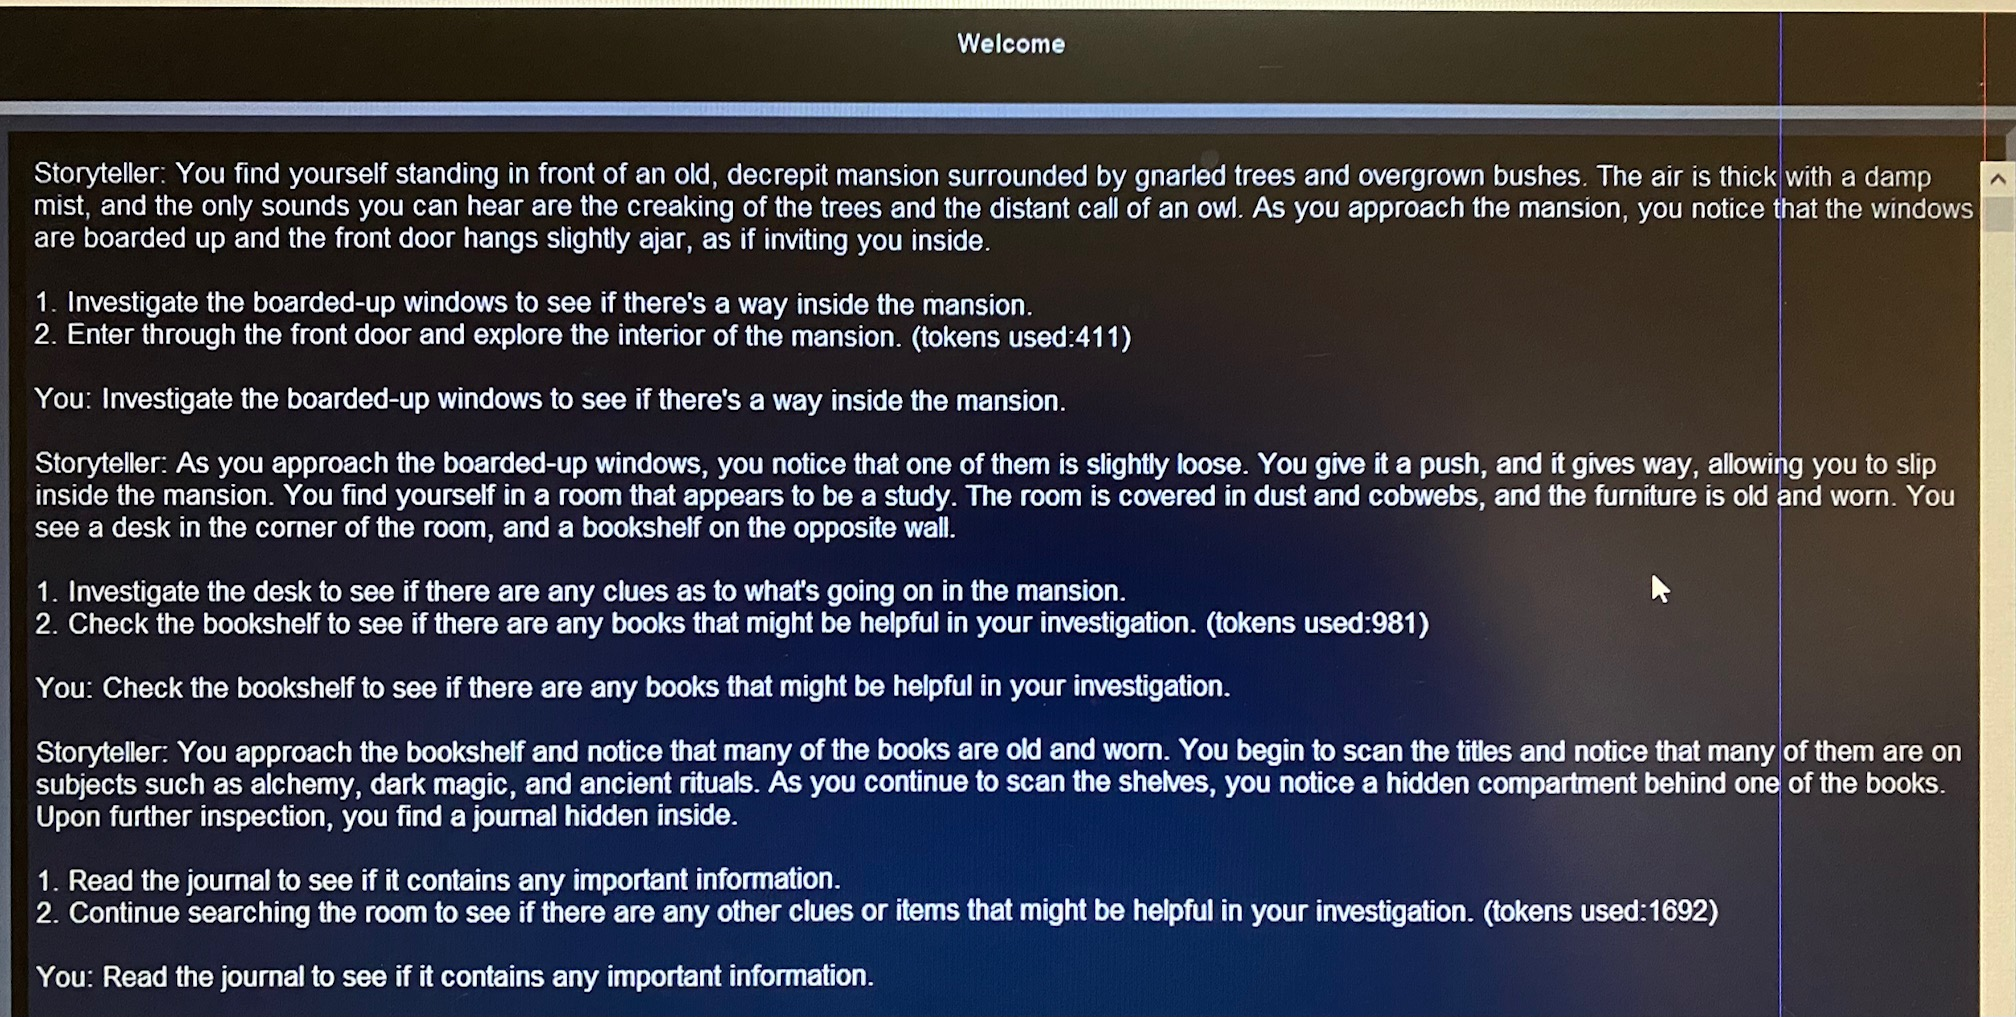
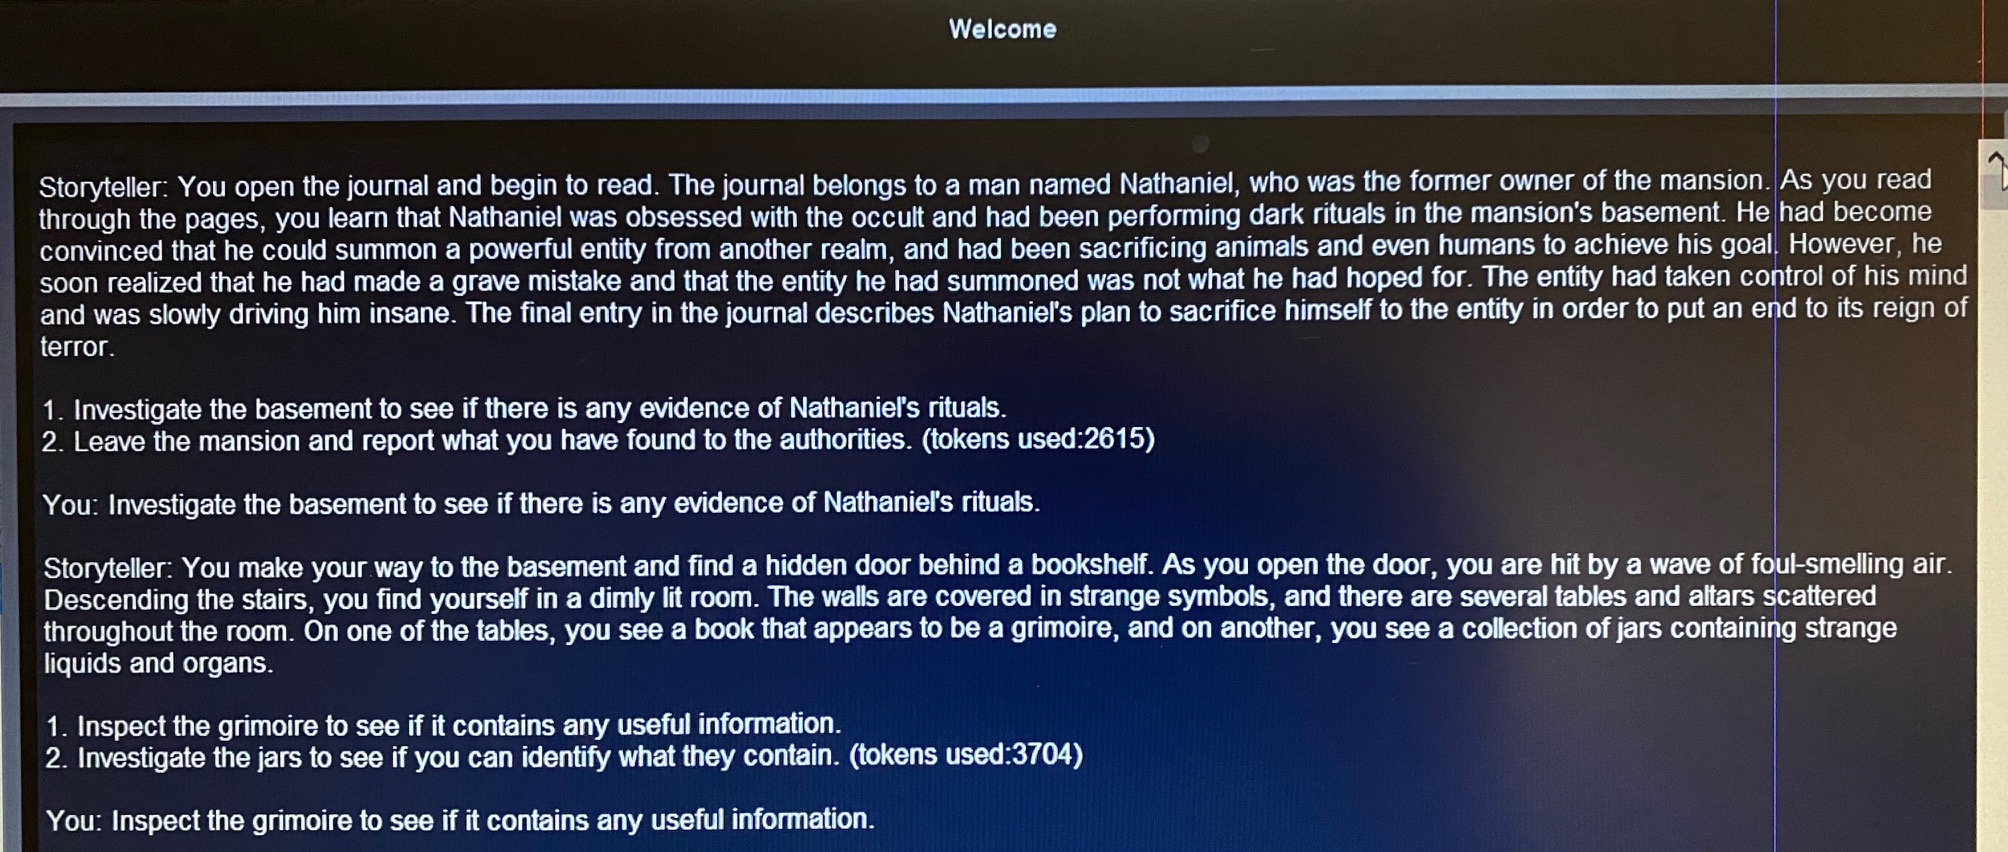
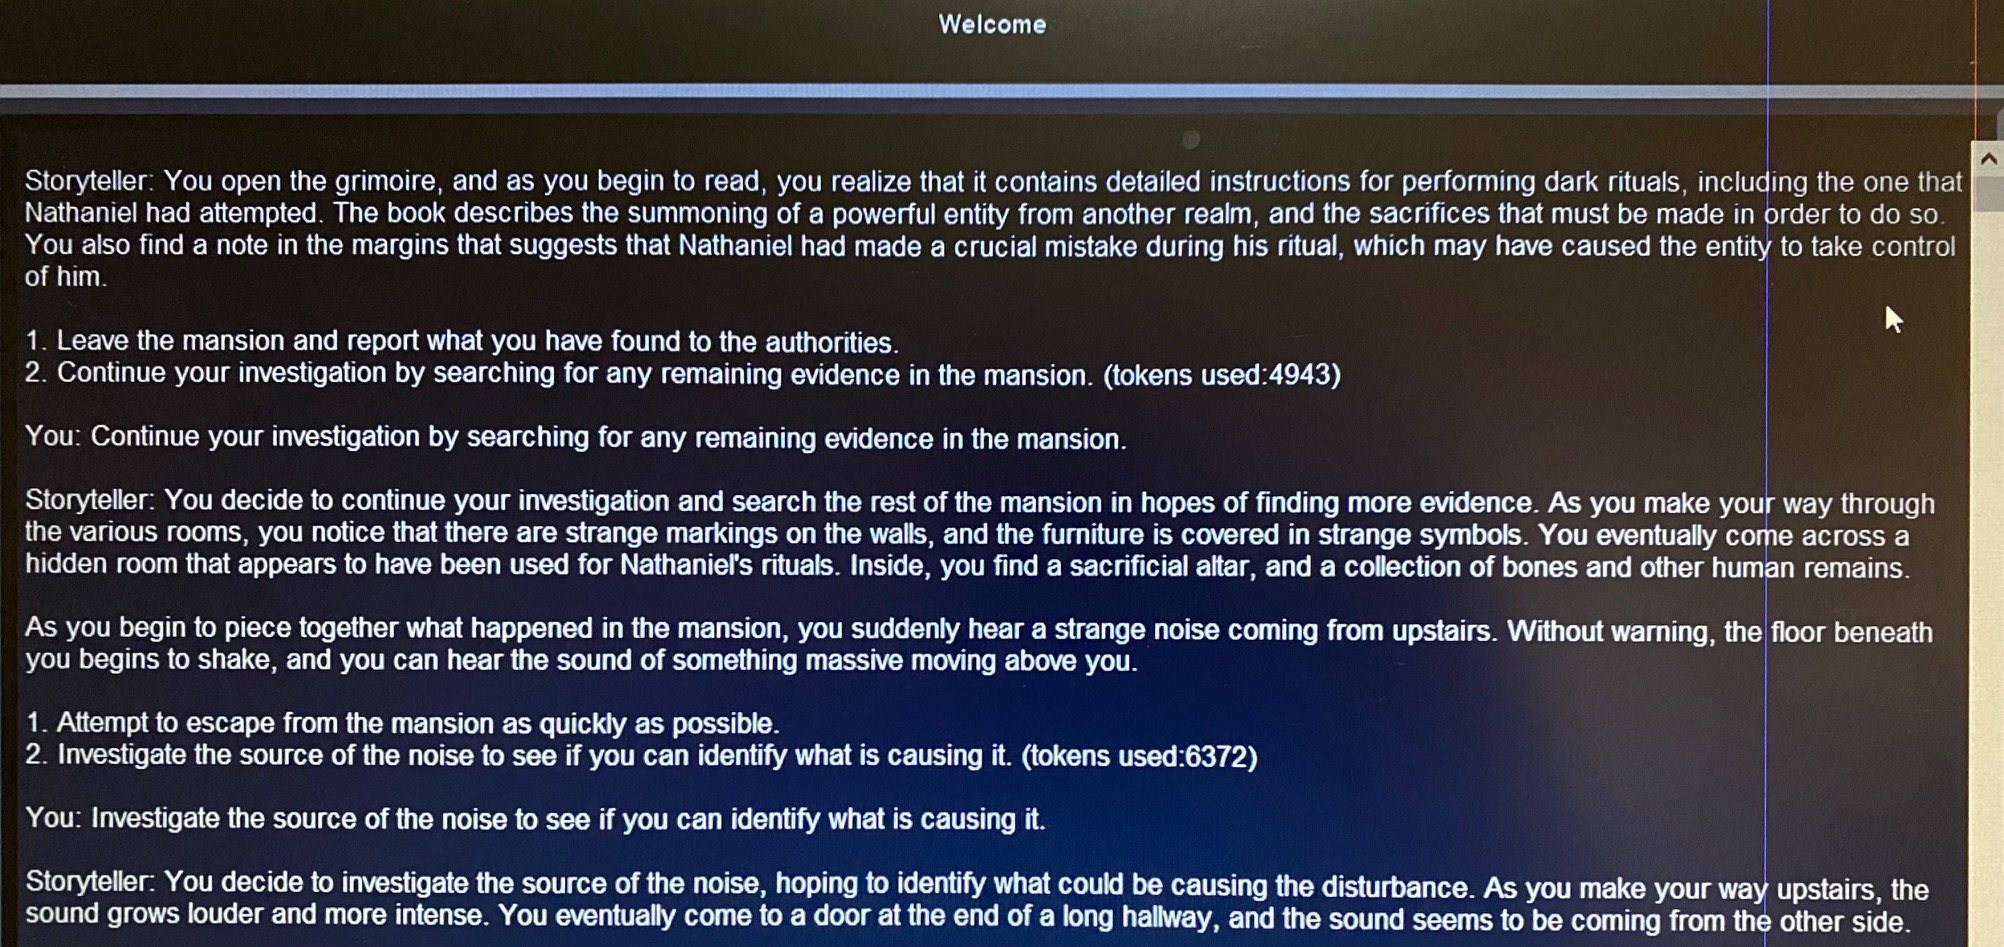
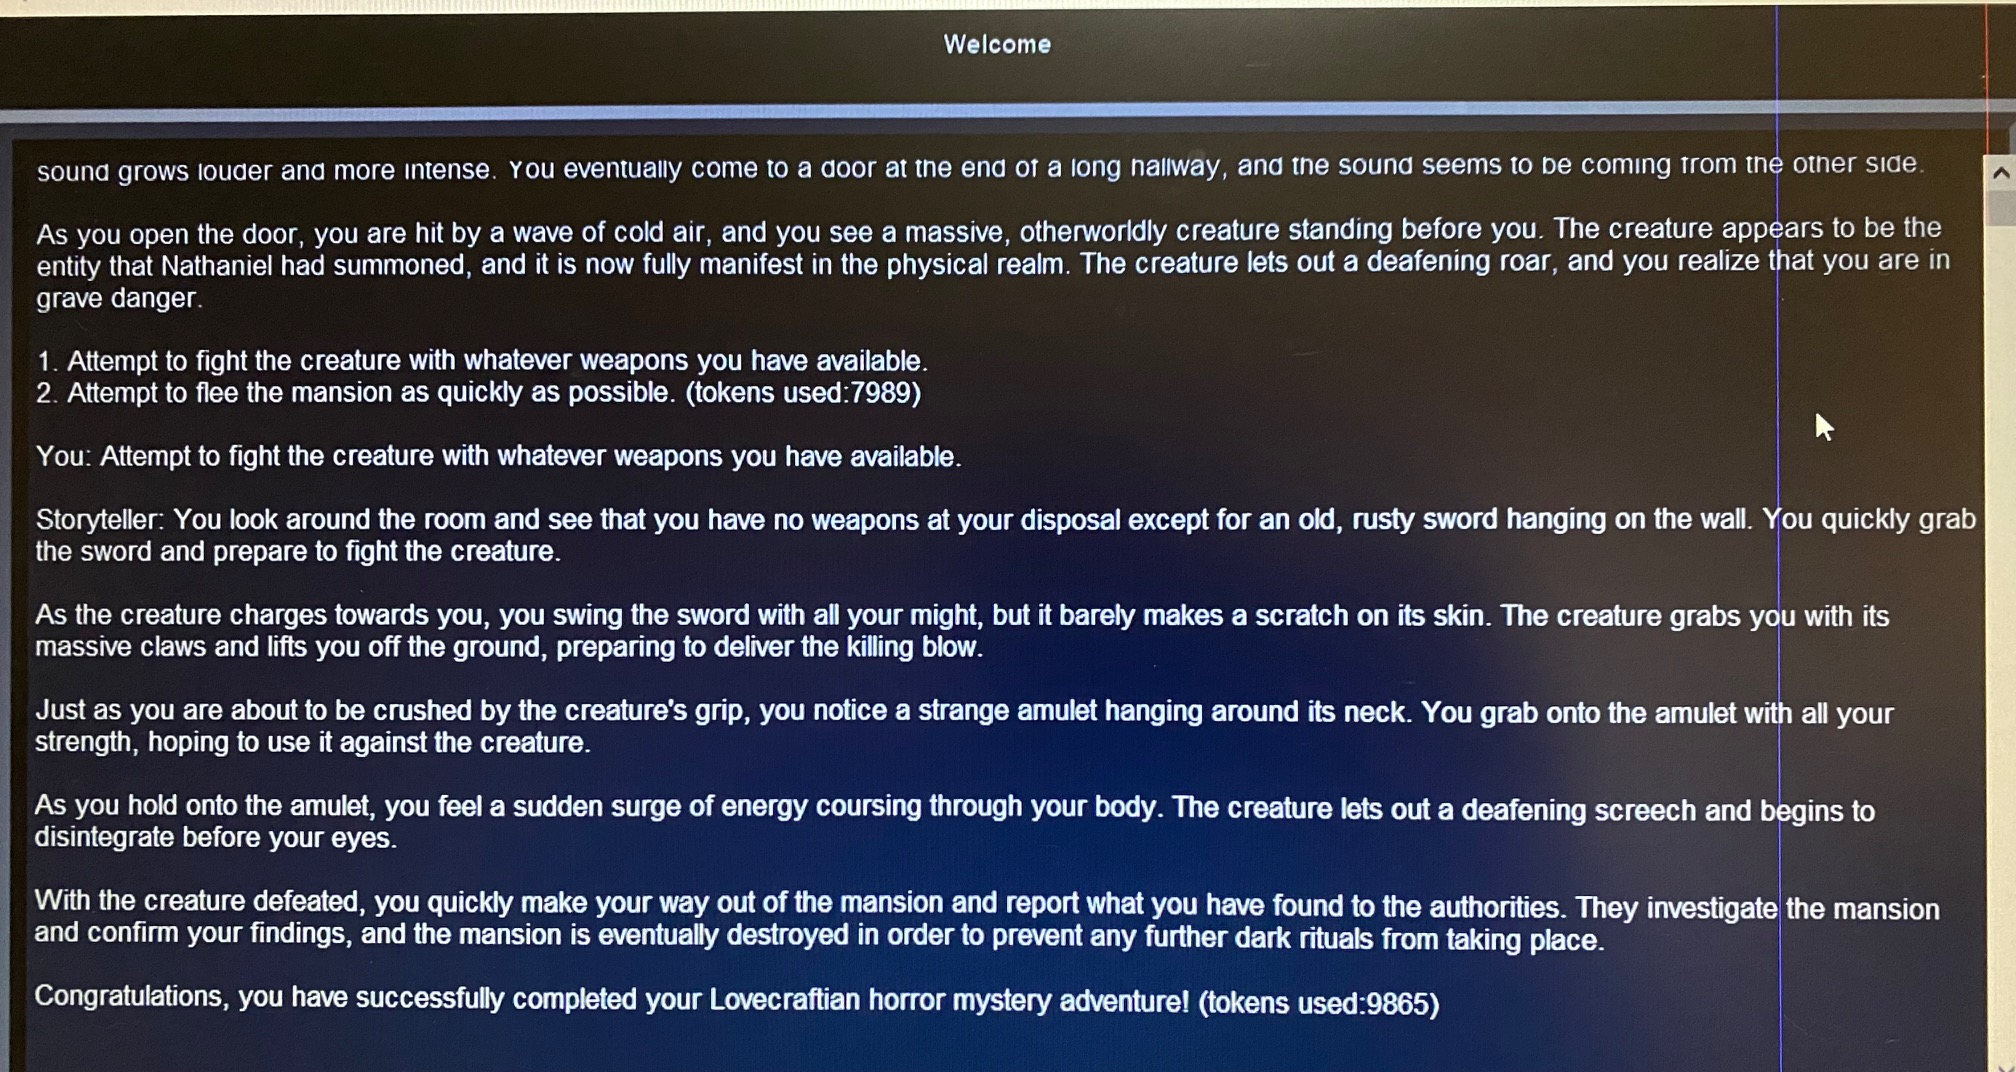


As instructed in the 'system-content', Chat-Adventure GPT may also cause the adventurer to meet their demise, though it can feel all too abrupt:

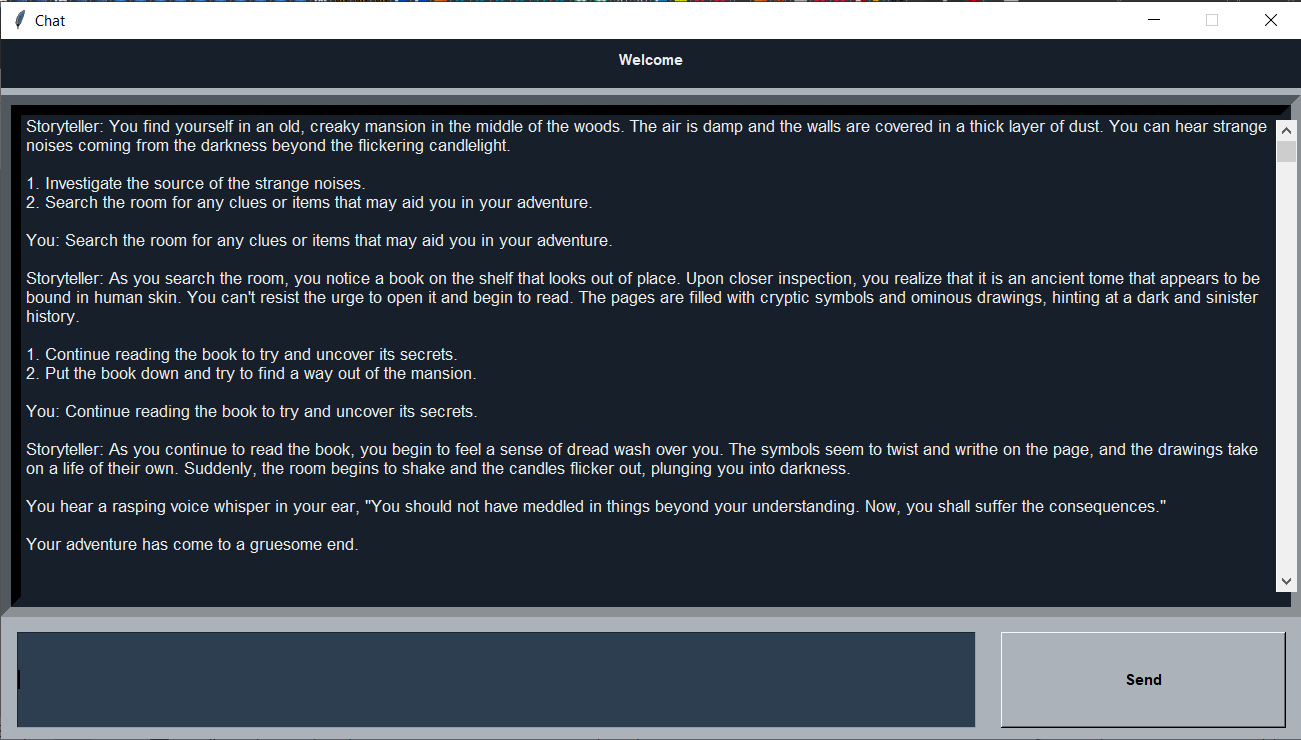

The instruction to bring the story to a conclusion within 10 user responses is not always 'robust', as in the considerably longer story below - when the story gets longer, Chat-Adventure GPT in its current form seems to have a penchant to become more repetitive. However, note the pleasant use of an 'open ended' ending to this adventure, as an example of ChatGPT's ability for spontaneous narrative flair!

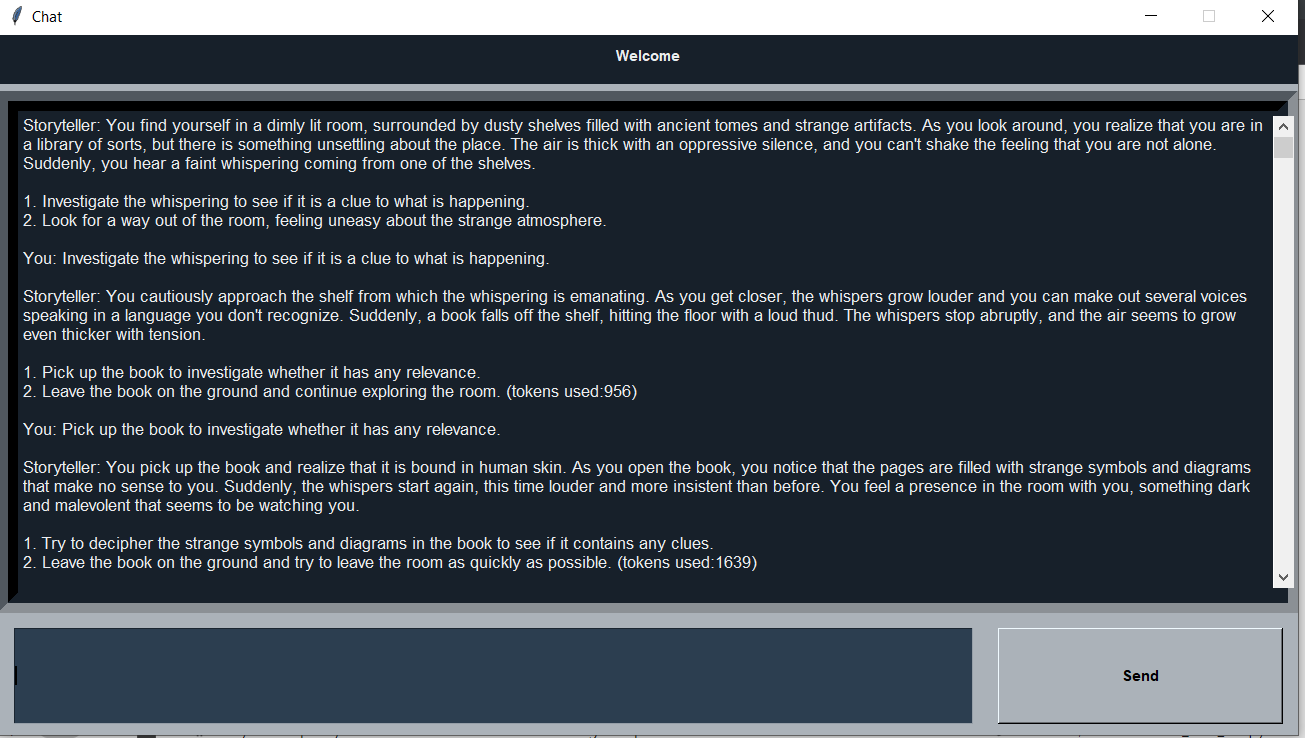
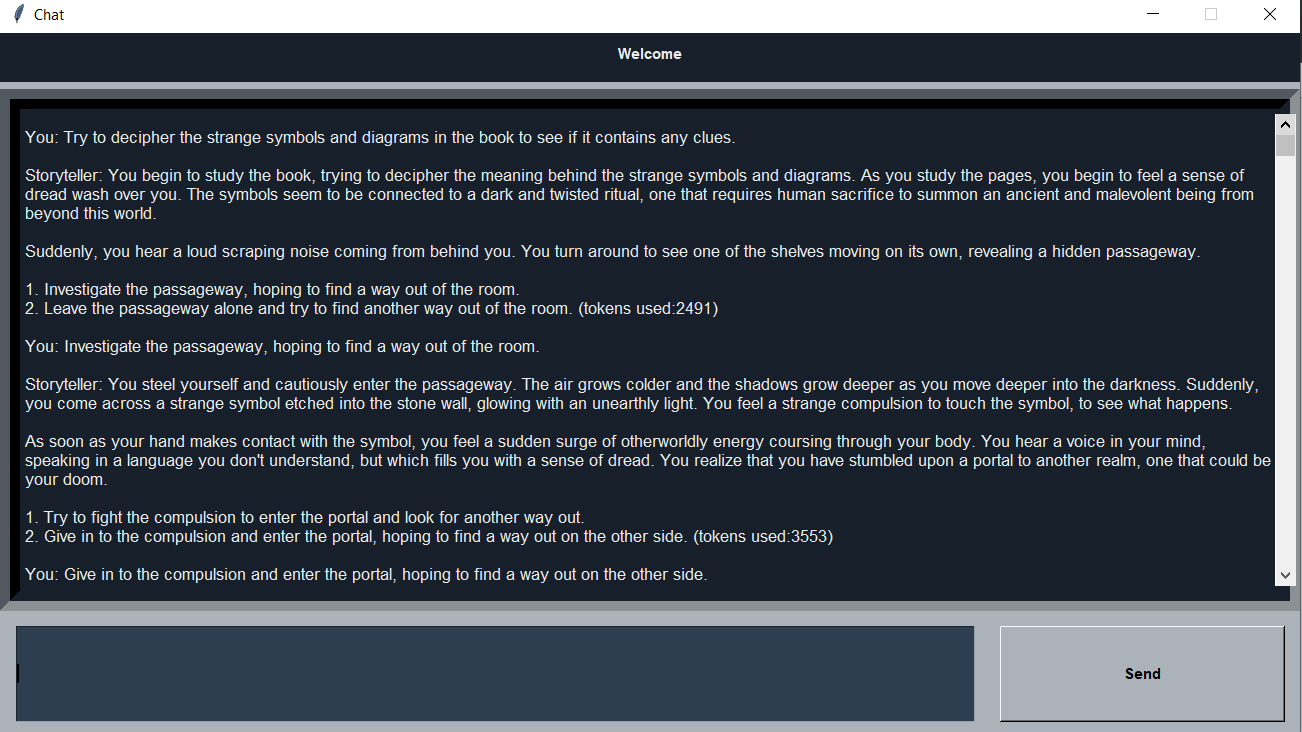
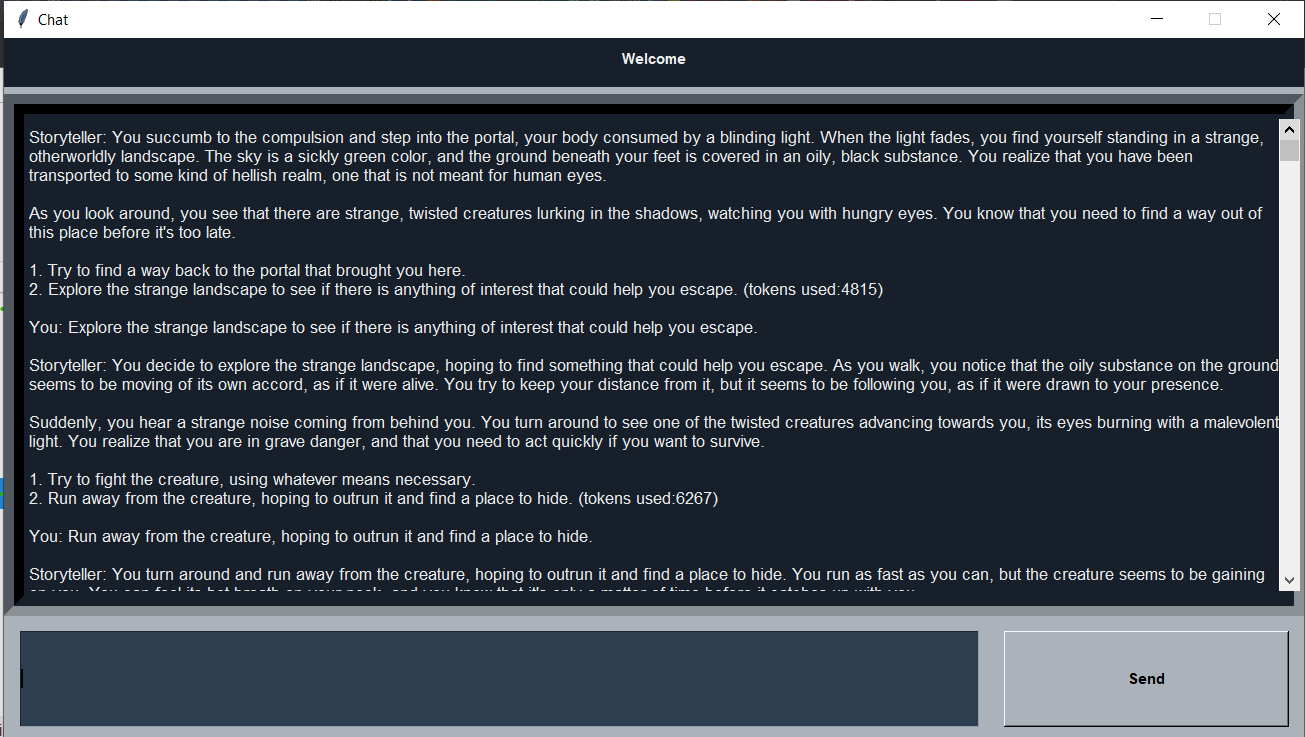
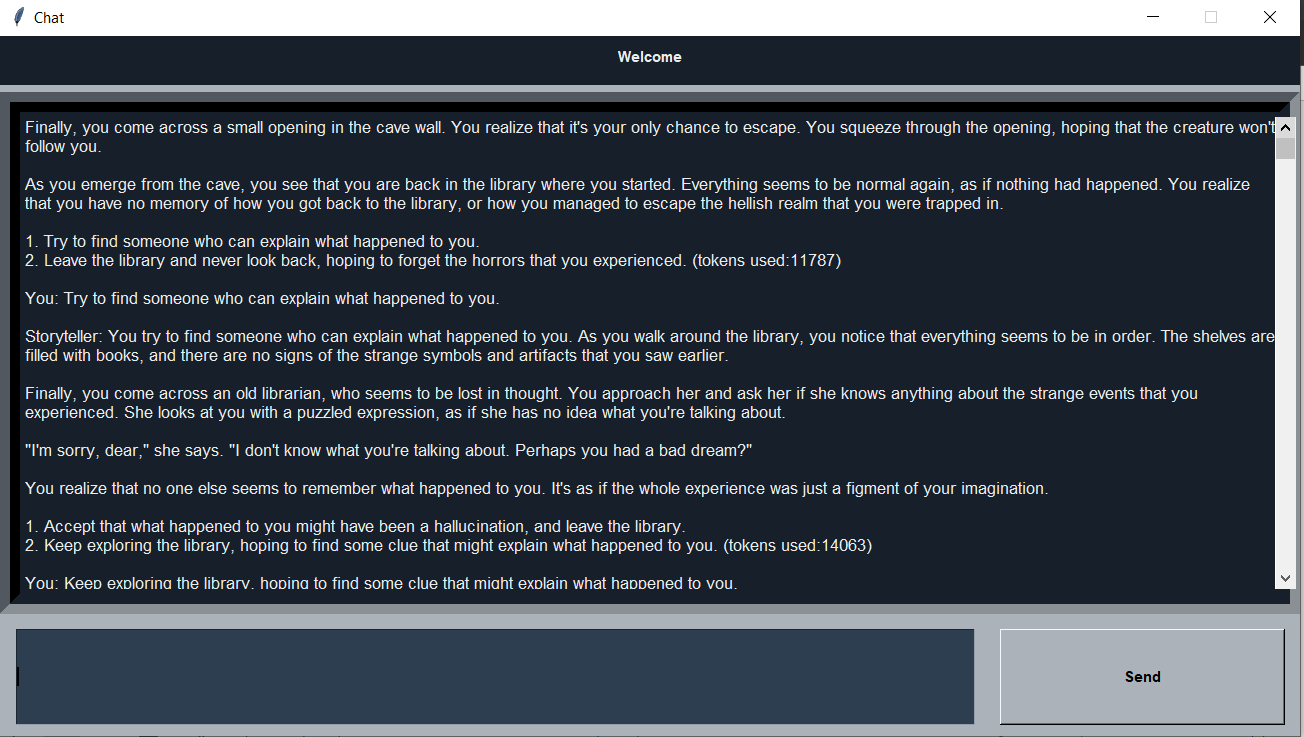
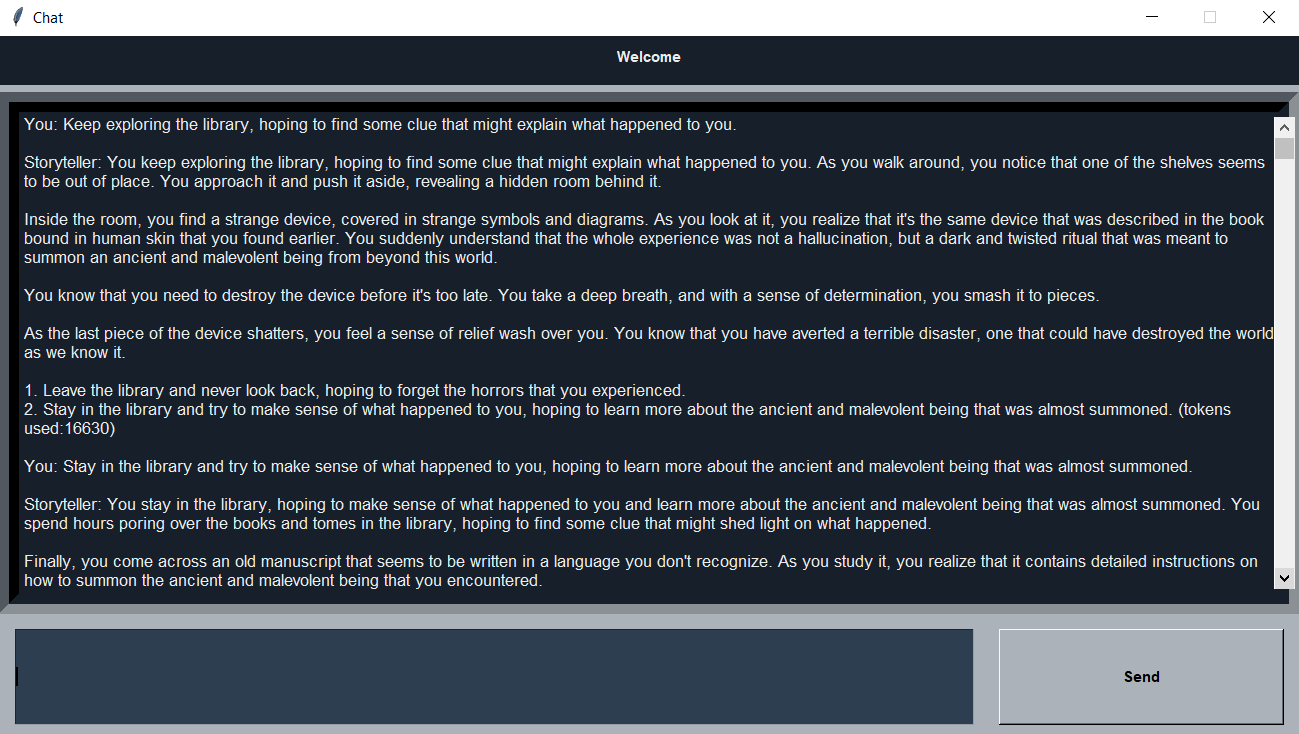
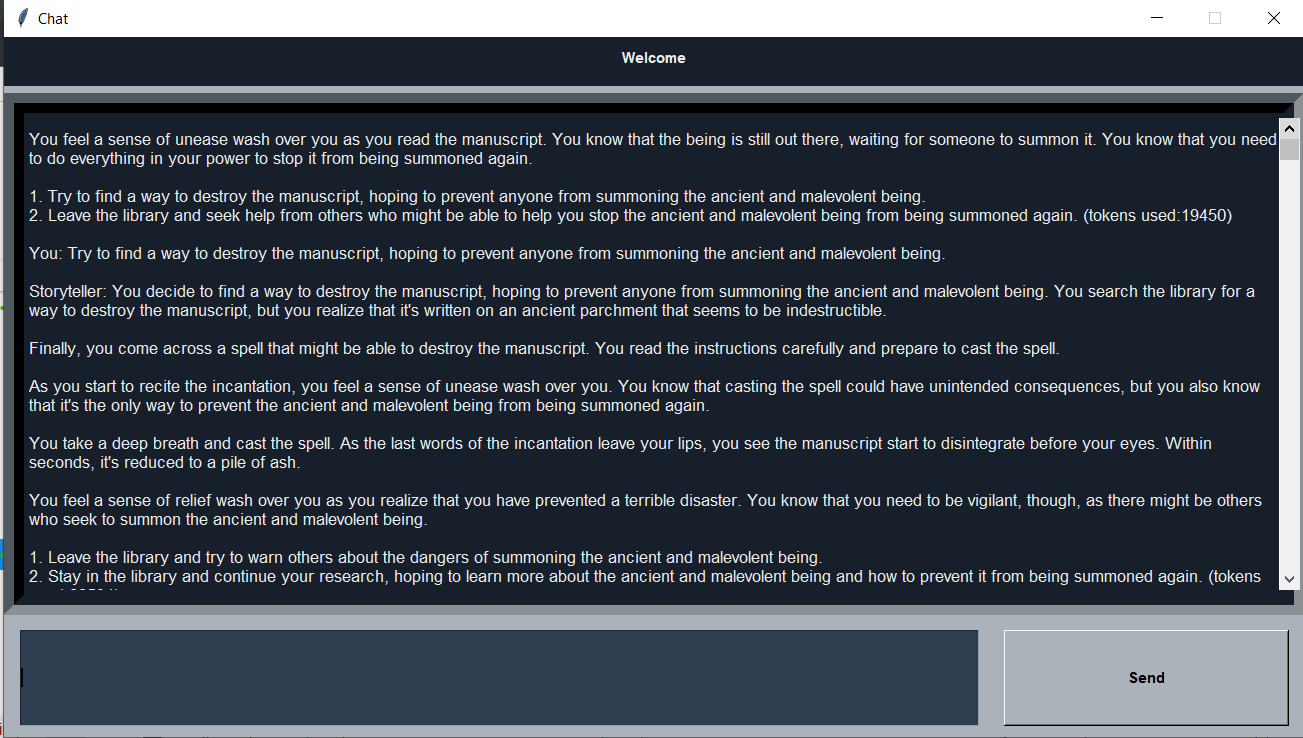
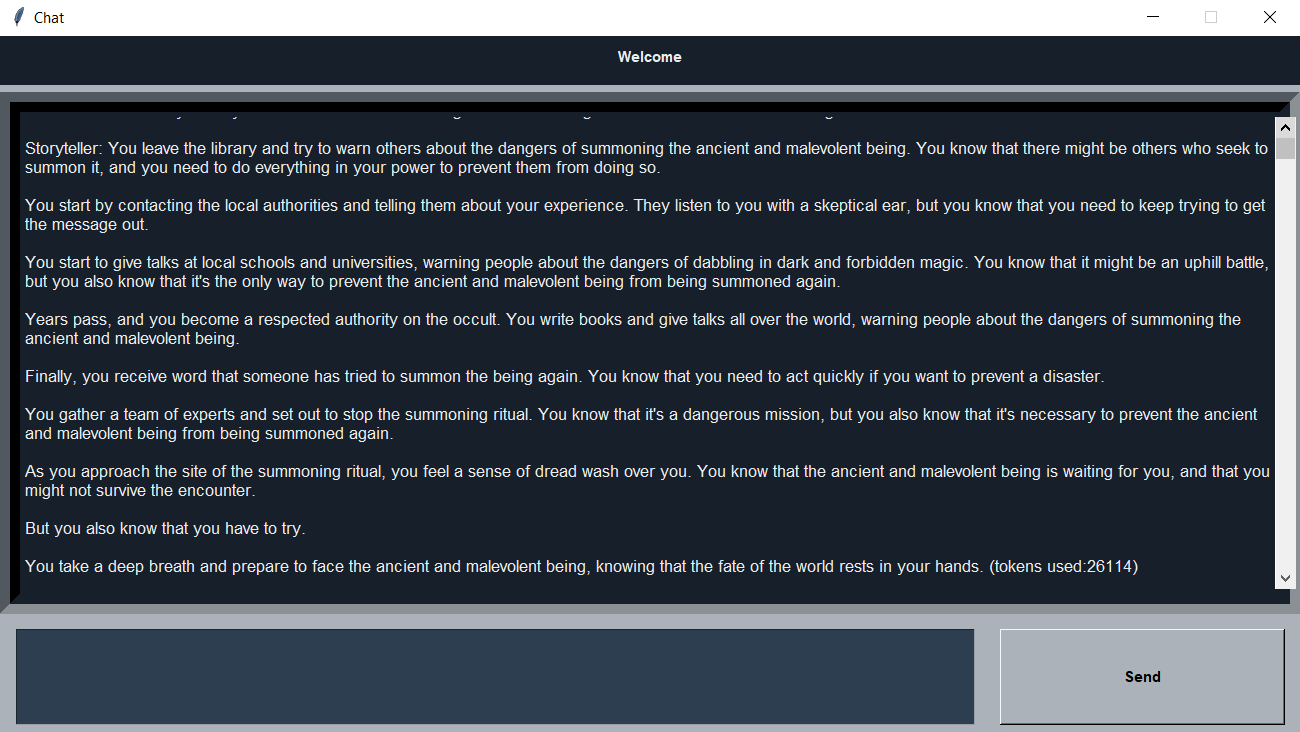